# Initial Setup

In [1]:
!pip install torchinfo torchviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.7 MB/s eta 0:00:00


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple
import math
import time

from dataclasses import dataclass # decorator for classes with less boilerplate: Auto-generates __init__, __repr__, etc.
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F # Functional interface for operations (activations, pooling, etc.)
import torch.optim as optim  # Optimization algorithms (SGD, Adam, etc.)
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset  # DataLoader: Handles batching, shuffling, parallel loading. Dataset: Abstract class for custom datasets

from torchinfo import summary
from torchviz import make_dot



# autocast: Automatic Mixed Precision - uses float16 where possible to speed up training while maintaining float32 for operations that need precision
# GradScaler: Scales gradients to prevent underflow when using float16.  Essential for stable mixed precision training
from torch.cuda.amp import autocast, GradScaler

from functools import partial # Creates partial functions by fixing some arguments. Useful for creating customized functions from general ones




np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
  torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.6.0+cu124


### Helper for Visualization of Attention

In [7]:
def visualize_attention(attention_weights, tokens=None, title="Attention Weights"):
  """
  Visualize attetion weight matrix

  attention_weights: 2D tensor/array where element [i,j] shows how much
                    query position i attends to key position j
  tokens: Optional list of token strings for axis labels
  title: Plot title

  Attention weights show which parts of input the model focuses on
  Darker colors = higher attention scores
  """

  plt.figure(figsize=(10,8))

  sns.heatmap(
      attention_weights,
      cmap="Blues",
      cbar=True,
      square=True,
      xticklabels=tokens if tokens else False,
      yticklabels=tokens if tokens else False
  )
  plt.title(title)
  plt.xlabel("Keys")
  plt.ylabel("Queries")
  plt.show()


# Simplified Dot-Product Attention (Vanilla)

In [49]:
def simplified_attention(X):
  """
  Simplified attention mechanism
  ai = Σ αij*xj where αij = softmax(xi·xj)
  """

  N,d = X.shape  # N = number of tokens/positions, d = embedding dimension
  print(f"Input shape: {X.shape} (N={N} tokens, d={d} dims)")

  # Compute similarity scores with dot prod
  scores = np.zeros((N,N)) # (All the tokens x All the tokens) matrix
  for i in range(N):
    for j in range(N):
      if j <= i: # Causal mask, only attending to prev tokens. Token at position i can only "see" positions 0 to i
        scores[i,j] = np.dot(X[i], X[j])
      else:
        scores[i,j] = -np.inf

  print(f"\nScores shape: {scores.shape}")
  print(f"Scores:\n {np.round(scores,4)}\n")

  # Apply softmax for attention weights
  attention_weights = np.zeros_like(scores) # Return an array of zeros with the same shape and type as a given array.

  for i in range(N):
    exp_scores = np.exp(scores[i] - np.max(scores[i]))    #NUMERICAL STABILITY TRICK: Subtract max before exponentiating
    print("\nexp_scores: ", exp_scores)
    attention_weights[i] = exp_scores / np.sum(exp_scores) # Normalize to get probs
    print(f"attention_weights[{i}]:\n ", attention_weights[i],"\n")


  print(f"attention_weights:\n ", np.round(attention_weights,3),"\n")

  print("attention_weights.shape:\n", attention_weights.shape)
  print("\n\n")


  print("Computation of Outputs\n")
  # Weighted sum for output
  output = np.zeros_like(X) # shape (N,d)
  for i in range(N):
    for j in range(i+1): # Only sum over positions we can attend to (causal)
      output[i] += attention_weights[i,j] * X[j] # Each output token is a weighted combination of input tokens
      print(f"output[{i}]: Embedding {output[i]} +=  Attention weight({attention_weights[i,j]}) * Input ({X[j]}) \n")


  print(f"Output:\n {output}")

  print(f"Output shape: {output.shape}")
  return output, attention_weights


#### Simple test

Input shape: (8, 4) (N=8 tokens, d=4 dims)

Scores shape: (8, 8)
Scores:
 [[ 2.8415    -inf    -inf    -inf    -inf    -inf    -inf    -inf]
 [-2.5763  6.7962    -inf    -inf    -inf    -inf    -inf    -inf]
 [ 0.5297 -2.6484  2.3102    -inf    -inf    -inf    -inf    -inf]
 [ 0.7838  1.9052 -1.7444  2.2002    -inf    -inf    -inf    -inf]
 [-0.8023  1.1253  0.7682 -0.8999  2.1772    -inf    -inf    -inf]
 [-0.4523  2.4412 -1.9382  1.7338 -1.0679  1.9957    -inf    -inf]
 [-0.8038 -1.925   1.0728 -1.4434 -0.8719 -0.5179  2.5597    -inf]
 [ 1.8764 -0.0313 -1.8814  2.084  -1.2842  1.2295 -1.8733  3.8535]]


exp_scores:  [1. 0. 0. 0. 0. 0. 0. 0.]
attention_weights[0]:
  [1. 0. 0. 0. 0. 0. 0. 0.] 


exp_scores:  [8.50325724e-05 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
attention_weights[1]:
  [8.50253425e-05 9.99914975e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00] 


exp_score

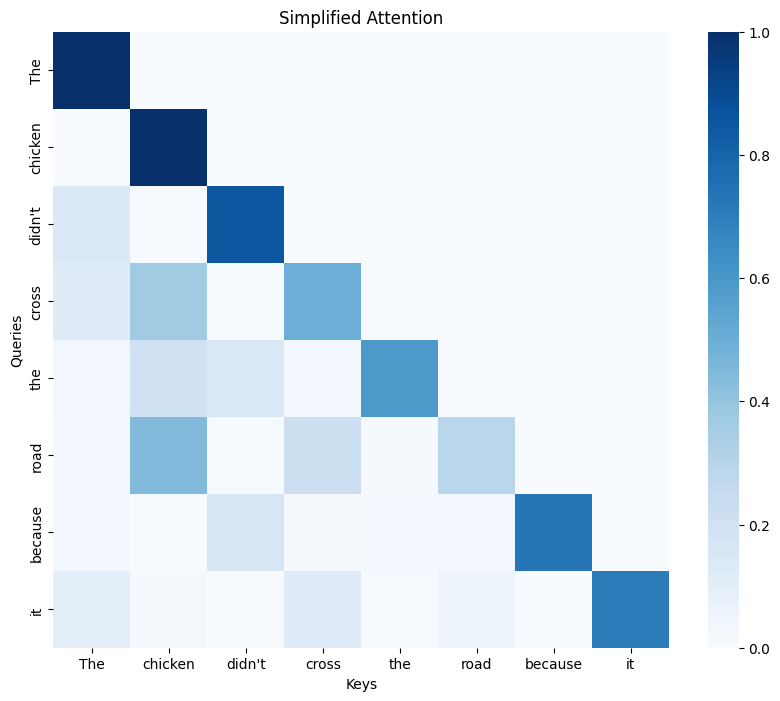

In [50]:
tokens = ["The", "chicken", "didn't", "cross", "the", "road", "because", "it"]
X = np.random.randn(len(tokens), 4)  # 8 tokens, 4 dims. In real models, dimensions are typically 512, 768, or 1024
output, weights = simplified_attention(X)

# Viz
visualize_attention(weights[:, :len(tokens)], tokens, "Simplified Attention")
